In [152]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from pathlib import Path
import cv2
import time
import random
from PIL import Image 

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from pathlib import Path
import cv2
import time
import random
from PIL import Image 

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from keras import utils
from torchvision import datasets, transforms
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionResNetV2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("All Libraries Imported Successfully")

All Libraries Imported Successfully


# Data Preprocessing & EDA

In [2]:
IMAGE_SIZE = (128, 128)  # Resize all images to 128x128
NUM_CLASSES = 4  # Number of classes: A, D, N, G
CLASS_MAPPING = {'A': 0, 'D': 1, 'N': 2, 'G': 3}

In [3]:
train_folder = "/kaggle/input/fives-a-fundus-image/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original"
test_folder = "/kaggle/input/fives-a-fundus-image/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original"

In [4]:
def load_images_from_folder(folder):
    images = []
    labels = []

    # List all files in the folder
    for file_name in os.listdir(folder):
        try:
            # Extract label from file name (e.g., "123_A.png")
            if "_" in file_name and file_name.endswith(".png"):
                _, disease = file_name.split("_")
                disease = disease.split(".")[0]  # Remove the ".png" extension

                if disease in CLASS_MAPPING:
                    # Load and preprocess image
                    file_path = os.path.join(folder, file_name)
                    img = load_img(file_path, target_size=IMAGE_SIZE)
                    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
                    images.append(img_array)

                    # Map disease to class label
                    labels.append(CLASS_MAPPING[disease])
                else:
                    print(f"Unknown label found in file: {file_name}")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    # Convert to numpy arrays
    return np.array(images, dtype='float32'), np.array(labels, dtype='int')

In [5]:
train_images, train_labels = load_images_from_folder(train_folder)
test_images, test_labels = load_images_from_folder(test_folder)

In [6]:
train_labels = to_categorical(train_labels, NUM_CLASSES)
test_labels = to_categorical(test_labels, NUM_CLASSES)

In [28]:
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")


Train images shape: (600, 128, 128, 3), Train labels shape: (600, 4)
Test images shape: (200, 128, 128, 3), Test labels shape: (200, 4)


In [8]:
from collections import Counter

# Decode one-hot encoded labels to class indices
decoded_train_labels = np.argmax(train_labels, axis=1)

decoded_test_labels = np.argmax(test_labels, axis=1)

# Count classes in train, validation, and test labels
train_class_counts = Counter(decoded_train_labels)

test_class_counts = Counter(decoded_test_labels)

# Map class indices back to labels
reverse_class_mapping = {v: k for k, v in CLASS_MAPPING.items()}

print("Train Class Distribution:")
for class_idx, count in train_class_counts.items():
    print(f"{reverse_class_mapping[class_idx]}: {count} images")

print("\nTest Class Distribution:")
for class_idx, count in test_class_counts.items():
    print(f"{reverse_class_mapping[class_idx]}: {count} images")


Train Class Distribution:
G: 150 images
D: 150 images
N: 150 images
A: 150 images

Test Class Distribution:
D: 50 images
G: 50 images
N: 50 images
A: 50 images


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,        # Rotate images up to 20 degrees
    width_shift_range=0.2,    # Shift images horizontally up to 20% of the width
    height_shift_range=0.2,   # Shift images vertically up to 20% of the height
    shear_range=0.2,          # Shear transformations
    zoom_range=0.2,           # Zoom in or out by 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill in missing pixels with the nearest value
)


In [10]:

test_datagen = ImageDataGenerator()


In [11]:
train_datagen.fit(train_images)

test_datagen.fit(test_images)


In [12]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

In [ ]:
import matplotlib.pyplot as plt

# Generate augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot a few examples
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


In [14]:
# Model Architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,  # Number of batches per epoch
    epochs=50
)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.2415 - loss: 1.5124
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.3125 - loss: 1.3460
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.4476 - loss: 1.2136
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.5000 - loss: 1.1595
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.4223 - loss: 1.1554
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 0.4375 - loss: 1.2224
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.4924 - loss: 1.1374
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - accuracy: 0.5000 - loss: 1.1017
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4439 - loss: 1.1791
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - accuracy: 0.4583 - loss: 1.0311
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5100 - loss: 1.0868
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - accuracy: 0.3438 - loss: 1.3723
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5296 - loss: 1.0436
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.

In [16]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5347 - loss: 1.1183
Test Loss: 1.0682834386825562, Test Accuracy: 0.5400000214576721


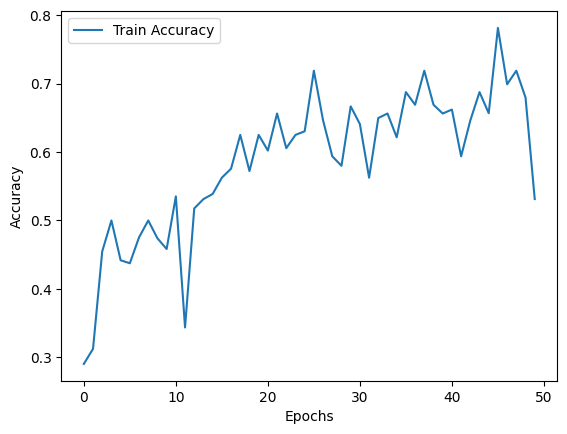

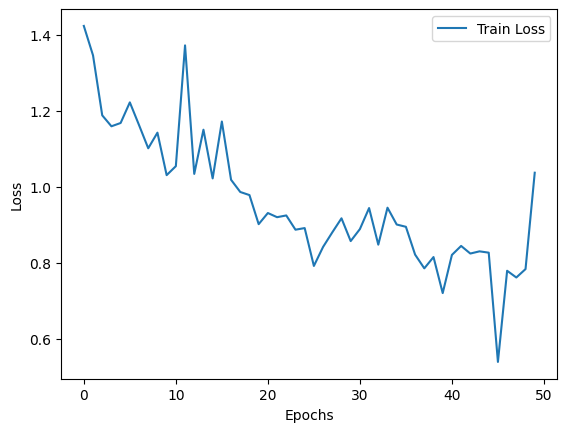

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# VGG16

In [18]:
vgg16 = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [42]:
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")


Train images shape: (600, 128, 128, 3), Train labels shape: (600, 4)
Test images shape: (200, 128, 128, 3), Test labels shape: (200, 4)


In [19]:
for layer in vgg16.layers:
    layer.trainable = False

In [32]:
flat = Flatten()(vgg16.output)

dense1 = Dense(64, kernel_initializer='he_uniform')(flat)
act1 = Activation('relu')(dense1)

dense2 = Dense(128, kernel_initializer='he_uniform')(act1)
act2 = Activation('relu')(dense2)

dense3 = Dense(256, kernel_initializer='he_uniform')(act2)
act3 = Activation('relu')(dense3)

dense4 = Dense(128, kernel_initializer='he_uniform')(act3)
act4 = Activation('relu')(dense4)

dense5 = Dense(64, kernel_initializer='he_uniform')(act4)
act5 = Activation('relu')(dense5)

output = Dense(4, activation='softmax')(act5)

In [33]:
final_vgg16 = Model(inputs=vgg16.input,outputs=output)

In [34]:
final_vgg16.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [23]:
history = final_vgg16.fit(
train_generator,# Validation data and labels
    batch_size=32,
    epochs=30
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.2896 - loss: 1.5268
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.4879 - loss: 1.1702
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5109 - loss: 1.0719
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5846 - loss: 0.9941
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5719 - loss: 0.9422
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.6247 - loss: 0.8637
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5514 - loss: 1.0033
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6473 - loss: 0.8503
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5919 - loss: 0.8587
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6096 - loss: 0.8877
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6416 - loss: 0.8878
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accurac

In [35]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5347 - loss: 1.1183 
Test Loss: 1.0682834386825562, Test Accuracy: 0.5400000214576721


In [36]:
final_2 = Model(inputs=vgg16.input,outputs=output)

In [37]:
final_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")


Train images shape: (600, 128, 128, 3), Train labels shape: (600, 4)
Test images shape: (200, 128, 128, 3), Test labels shape: (200, 4)


In [45]:
history = final_2.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9614 - loss: 0.1254
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8960 - loss: 0.2573
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9050 - loss: 0.2404
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9222 - loss: 0.2084
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9653 - loss: 0.1103
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9695 - loss: 0.1195
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9735 - loss: 0.0753
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8724 - loss: 0.3236
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9313 - loss: 0.1643
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9599 - loss: 0.1248
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9343 - loss: 0.1657
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy:

In [50]:
import numpy as np

# Predict the test data
y_pred = final_2.predict(test_images)

# Convert predictions and true labels to their respective classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class
y_true_classes = np.argmax(test_labels, axis=1)  # True class


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


In [51]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 1       0.79      0.68      0.73        50
     Class 2       0.67      0.80      0.73        50
     Class 3       1.00      0.34      0.51        50
     Class 4       0.55      0.88      0.68        50

    accuracy                           0.68       200
   macro avg       0.75      0.68      0.66       200
weighted avg       0.75      0.68      0.66       200



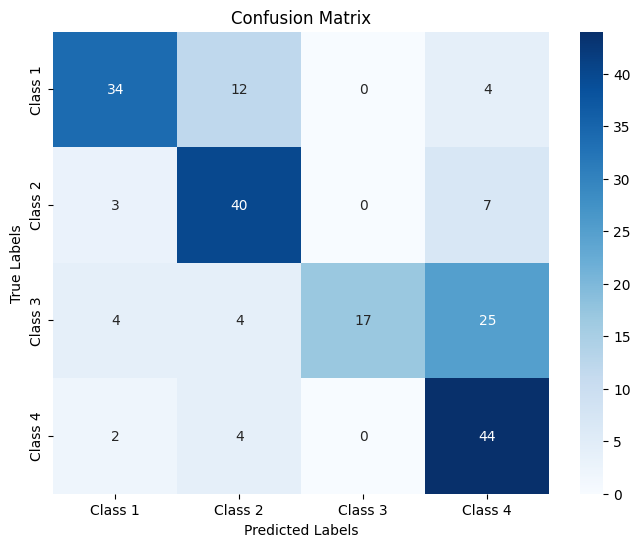

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [53]:
final_2.save("VGG16_FIVE.h5")

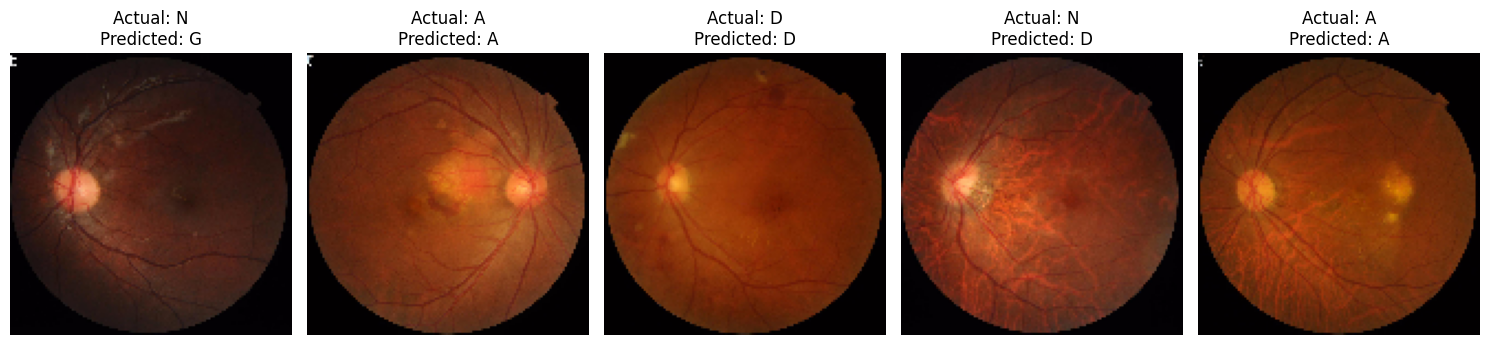

In [57]:
import matplotlib.pyplot as plt

# Invert CLASS_MAPPING to get label-to-class mapping
CLASS_MAPPING = {'A': 0, 'D': 1, 'N': 2, 'G': 3}
LABEL_MAPPING = {v: k for k, v in CLASS_MAPPING.items()}

# Select 5 random images from the test dataset
indices = np.random.choice(len(test_images), 5, replace=False)

# Plot the images with actual and predicted labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    image = test_images[idx]
    actual_label = LABEL_MAPPING[np.argmax(test_labels[idx])]
    predicted_label = LABEL_MAPPING[np.argmax(y_pred[idx])]

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()


# VGG19

In [54]:
vgg19 = VGG19(input_shape=(128,128,3), weights='imagenet', include_top=False)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [58]:
for layer in vgg19.layers:
    layer.trainable = False

In [60]:
x = Flatten()(vgg19.output)
dense1 = Dense(64, kernel_initializer='he_uniform')(x)
act1 = Activation('relu')(dense1)

dense2 = Dense(128, kernel_initializer='he_uniform')(act1)
act2 = Activation('relu')(dense2)

dense3 = Dense(256, kernel_initializer='he_uniform')(act2)
act3 = Activation('relu')(dense3)

dense4 = Dense(128, kernel_initializer='he_uniform')(act3)
act4 = Activation('relu')(dense4)

dense5 = Dense(64, kernel_initializer='he_uniform')(act4)
act5 = Activation('relu')(dense5)

predictions = Dense(4, activation='softmax')(act5)

In [62]:
final_vgg19 = Model(inputs=vgg19.input,outputs=predictions)

In [63]:
final_vgg19.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [64]:
history = final_vgg19.fit(
train_generator,# Validation data and labels
    batch_size=32,
    epochs=30
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.2513 - loss: 1.5597
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.4421 - loss: 1.2674
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4944 - loss: 1.1388
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5222 - loss: 1.0424
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5393 - loss: 1.0266
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5902 - loss: 0.9445
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5580 - loss: 0.9771
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5873 - loss: 0.9416
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5471 - loss: 1.0029
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5568 - loss: 0.9437
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6167 - loss: 0.8903
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy

In [67]:
final_vgg19_2 = Model(inputs=vgg16.input,outputs=output)

In [68]:
final_vgg19_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
history = final_vgg19_2.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9134 - loss: 0.3369
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9834 - loss: 0.0495
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9686 - loss: 0.0697
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9852 - loss: 0.0358
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9860 - loss: 0.0359
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9682 - loss: 0.0973
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9516 - loss: 0.1503
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9566 - loss: 0.1170
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9971 - loss: 0.0327
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9789 - loss: 0.0549
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9878 - loss: 0.0406
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy:

In [72]:
test_loss, test_accuracy = final_vgg19_2.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6155 - loss: 2.6182
Test Loss: 2.5270919799804688, Test Accuracy: 0.625


In [73]:
import numpy as np

# Predict the test data
y_pred = final_vgg19_2.predict(test_images)

# Convert predictions and true labels to their respective classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class
y_true_classes = np.argmax(test_labels, axis=1)  # True class


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


In [74]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 1       0.78      0.70      0.74        50
     Class 2       0.57      0.80      0.67        50
     Class 3       1.00      0.16      0.28        50
     Class 4       0.55      0.84      0.66        50

    accuracy                           0.62       200
   macro avg       0.72      0.62      0.59       200
weighted avg       0.72      0.62      0.59       200



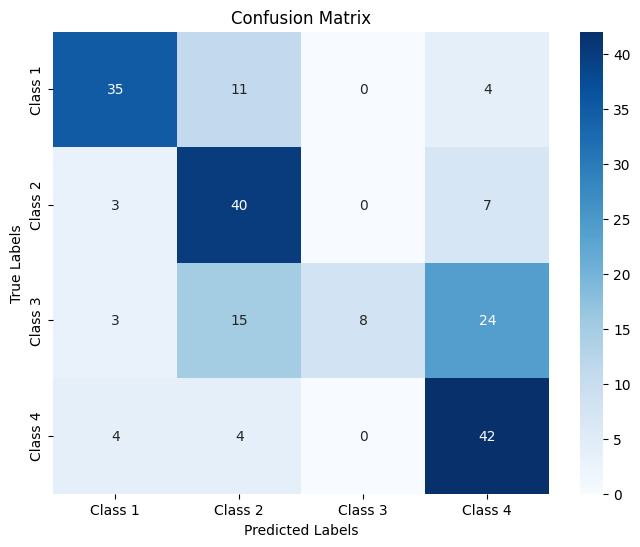

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


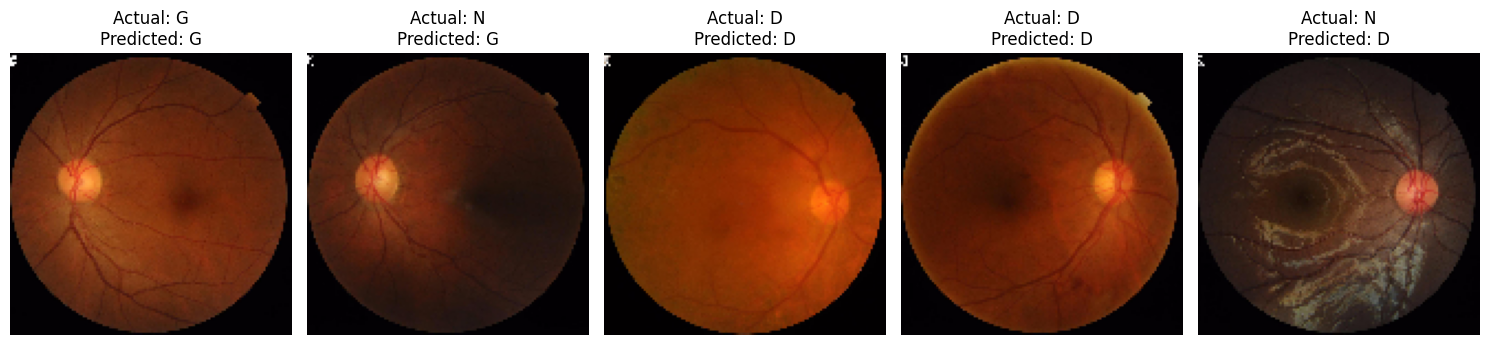

In [76]:
import matplotlib.pyplot as plt

# Invert CLASS_MAPPING to get label-to-class mapping
CLASS_MAPPING = {'A': 0, 'D': 1, 'N': 2, 'G': 3}
LABEL_MAPPING = {v: k for k, v in CLASS_MAPPING.items()}

# Select 5 random images from the test dataset
indices = np.random.choice(len(test_images), 5, replace=False)

# Plot the images with actual and predicted labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    image = test_images[idx]
    actual_label = LABEL_MAPPING[np.argmax(test_labels[idx])]
    predicted_label = LABEL_MAPPING[np.argmax(y_pred[idx])]

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()


In [77]:
final_vgg19_2.save("VGG19.h5")

# ResNet 50

In [79]:
resnet50 = ResNet50(input_shape=(128,128,3), weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [87]:
x = Flatten()(resnet50.output)

dense1 = Dense(64, kernel_initializer='he_uniform')(x)
bn1 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn1)

dense2 = Dense(128, kernel_initializer='he_uniform')(act1)
act2 = Activation('relu')(dense2)

dense3 = Dense(256, kernel_initializer='he_uniform')(act2)
act3 = Activation('relu')(dense3)

dense4 = Dense(128, kernel_initializer='he_uniform')(act3)
act4 = Activation('relu')(dense4)

dense5 = Dense(64, kernel_initializer='he_uniform')(act4)
act5 = Activation('relu')(dense5)

predictions = Dense(4, activation='softmax')(act5)

In [88]:
final_resnet50 = Model(inputs=resnet50.input, outputs=predictions)

In [89]:
final_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
history = final_resnet50.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5214 - loss: 1.1808
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8126 - loss: 0.5216
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8610 - loss: 0.3645
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8849 - loss: 0.3089
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9266 - loss: 0.2015
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9406 - loss: 0.1637
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9525 - loss: 0.1593
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9589 - loss: 0.1277
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9353 - loss: 0.1624
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9317 - loss: 0.2060
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9451 - loss: 0.1713
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 

In [98]:
history = final_resnet50.fit(
    train_generator,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8733 - loss: 0.3567
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8714 - loss: 0.3449
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8595 - loss: 0.4060
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9266 - loss: 0.2730
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8851 - loss: 0.2993
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8819 - loss: 0.2943
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8817 - loss: 0.3437
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8826 - loss: 0.3021
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8996 - loss: 0.2705
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9064 - loss: 0.2530
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8881 - loss: 0.2901
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy

In [99]:
test_loss, test_accuracy = final_resnet50.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6526 - loss: 1.3534
Test Loss: 1.259161114692688, Test Accuracy: 0.6700000166893005


In [102]:
import numpy as np

# Predict the test data
y_pred = final_resnet50.predict(test_images)

# Convert predictions and true labels to their respective classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class
y_true_classes = np.argmax(test_labels, axis=1)  # True class


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [104]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 1       0.85      0.90      0.87        50
     Class 2       0.52      0.76      0.62        50
     Class 3       0.75      0.12      0.21        50
     Class 4       0.68      0.90      0.78        50

    accuracy                           0.67       200
   macro avg       0.70      0.67      0.62       200
weighted avg       0.70      0.67      0.62       200



In [108]:
final_resnet50.save("resnet50.h5")

# Mobile Net

In [105]:
mobilenet = MobileNetV2(input_shape=(128,128,3), weights='imagenet', include_top=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [106]:
x = Flatten()(mobilenet.output)

dense1 = Dense(64, kernel_initializer='he_uniform')(x)
act1 = Activation('relu')(dense1)

dense2 = Dense(128, kernel_initializer='he_uniform')(act1)
act2 = Activation('relu')(dense2)

dense3 = Dense(256, kernel_initializer='he_uniform')(act2)
act3 = Activation('relu')(dense3)

dense4 = Dense(128, kernel_initializer='he_uniform')(act3)
act4 = Activation('relu')(dense4)

dense5 = Dense(64, kernel_initializer='he_uniform')(act4)
act5 = Activation('relu')(dense5)

predictions = Dense(4, activation='softmax')(act5)

In [107]:
final_mobilenet = Model(inputs=mobilenet.input, outputs=predictions)

In [112]:
final_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [120]:
history = final_mobilenet.fit(
    train_generator,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 778ms/step - accuracy: 0.6600 - loss: 1.5094
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7542 - loss: 0.7986
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7986 - loss: 0.6030
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8391 - loss: 0.5537
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8552 - loss: 0.4434
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8725 - loss: 0.3831
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8809 - loss: 0.3804
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8797 - loss: 0.3273
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8792 - loss: 0.3465
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8968 - loss: 0.3389
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9147 - loss: 0.2784
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accurac

In [114]:
test_loss, test_accuracy = final_mobilenet.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - accuracy: 0.3199 - loss: 2.1504
Test Loss: 2.1208319664001465, Test Accuracy: 0.33500000834465027


In [117]:
final_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
history = final_mobilenet.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 827ms/step - accuracy: 0.8676 - loss: 0.4591
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8985 - loss: 0.3497
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9413 - loss: 0.2304
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9410 - loss: 0.2664
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8957 - loss: 0.3671
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9580 - loss: 0.1423
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9426 - loss: 0.2273
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9423 - loss: 0.1849
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9280 - loss: 0.5773
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8862 - loss: 0.5733
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9141 - loss: 0.3771
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accurac

In [121]:
test_loss, test_accuracy = final_mobilenet.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4035 - loss: 7.1880
Test Loss: 7.274559497833252, Test Accuracy: 0.42500001192092896


In [122]:
import numpy as np

# Predict the test data
y_pred = final_mobilenet.predict(test_images)

# Convert predictions and true labels to their respective classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class
y_true_classes = np.argmax(test_labels, axis=1)  # True class


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 388ms/step


In [123]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 1       0.32      0.96      0.48        50
     Class 2       1.00      0.06      0.11        50
     Class 3       0.76      0.58      0.66        50
     Class 4       0.62      0.10      0.17        50

    accuracy                           0.42       200
   macro avg       0.68      0.43      0.36       200
weighted avg       0.68      0.42      0.36       200



In [132]:
final_mobilenet.save("mobilenet.h5")

# Inception

In [124]:
inception = InceptionResNetV2(input_shape=(128,128,3), weights='imagenet', include_top=False)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [125]:
x = inception.output
flat = Flatten()(x)

dense1 = Dense(64, kernel_initializer='he_uniform')(flat)
act1 = Activation('relu')(dense1)

dense2 = Dense(128, kernel_initializer='he_uniform')(act1)
act2 = Activation('relu')(dense2)

dense3 = Dense(256, kernel_initializer='he_uniform')(act2)
act3 = Activation('relu')(dense3)

dense4 = Dense(128, kernel_initializer='he_uniform')(act3)
act4 = Activation('relu')(dense4)

dense5 = Dense(64, kernel_initializer='he_uniform')(act4)
act5 = Activation('relu')(dense5)

predictions = Dense(4, activation='softmax')(act5)

In [126]:
final_inception = Model(inputs=inception.input,outputs=predictions)

In [130]:
final_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [131]:
history = final_inception.fit(
    train_generator,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.3654 - loss: 1.4426
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.6172 - loss: 0.9683
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.6104 - loss: 0.9808
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.6822 - loss: 0.8107
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.6949 - loss: 0.7980
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.7496 - loss: 0.6475
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.7829 - loss: 0.6276
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.7620 - loss: 0.6642
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.8021 - loss: 0.5745
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.8109 - loss: 0.5792
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.7629 - loss: 0.6462
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step 

In [136]:
test_loss, test_accuracy = final_inception.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7477 - loss: 1.4184
Test Loss: 1.2431453466415405, Test Accuracy: 0.7599999904632568


In [135]:
history = final_inception.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.8397 - loss: 0.4950
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.8918 - loss: 0.3372
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9427 - loss: 0.1665
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9298 - loss: 0.1781
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.8974 - loss: 0.3283
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.8996 - loss: 0.2821
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9358 - loss: 0.1779
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9380 - loss: 0.1476
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9629 - loss: 0.1214
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9800 - loss: 0.0593
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9700 - loss: 0.1671
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step 

In [137]:
final_inception.save("inception.h5")

In [138]:
import numpy as np

# Predict the test data
y_pred = final_inception.predict(test_images)

# Convert predictions and true labels to their respective classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class
y_true_classes = np.argmax(test_labels, axis=1)  # True class


7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


In [139]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 1       0.89      0.84      0.87        50
     Class 2       1.00      0.64      0.78        50
     Class 3       0.78      0.62      0.69        50
     Class 4       0.58      0.94      0.72        50

    accuracy                           0.76       200
   macro avg       0.81      0.76      0.76       200
weighted avg       0.81      0.76      0.76       200



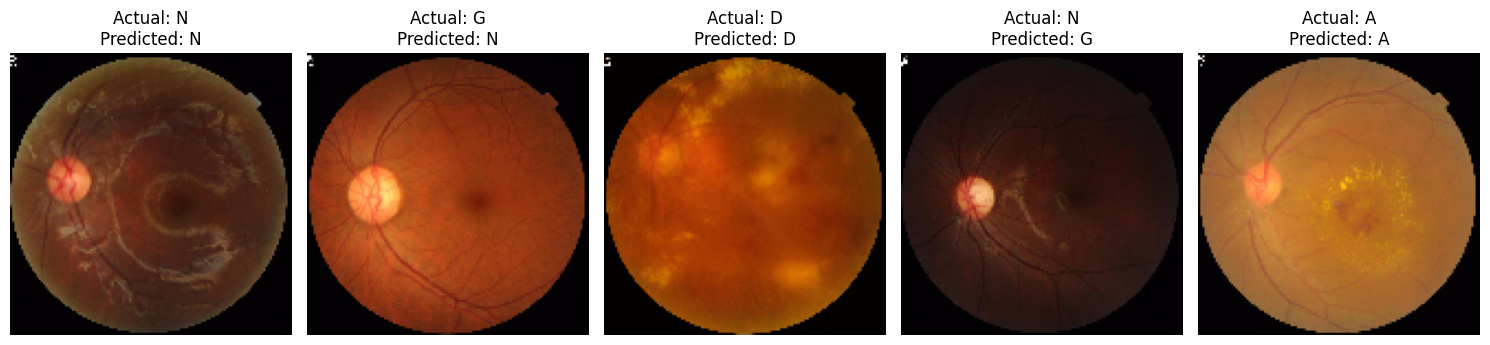

In [140]:
import matplotlib.pyplot as plt

# Invert CLASS_MAPPING to get label-to-class mapping
CLASS_MAPPING = {'A': 0, 'D': 1, 'N': 2, 'G': 3}
LABEL_MAPPING = {v: k for k, v in CLASS_MAPPING.items()}

# Select 5 random images from the test dataset
indices = np.random.choice(len(test_images), 5, replace=False)

# Plot the images with actual and predicted labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    image = test_images[idx]
    actual_label = LABEL_MAPPING[np.argmax(test_labels[idx])]
    predicted_label = LABEL_MAPPING[np.argmax(y_pred[idx])]

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()


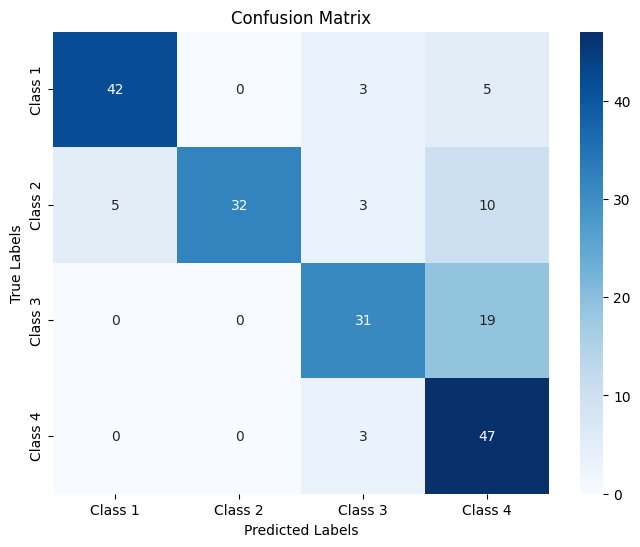

In [141]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Efficient Net

In [147]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

In [143]:
efficientnet = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128,128, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [148]:
flat = layers.Flatten()(efficientnet.output)
dense1 = layers.Dense(2048, activation="relu")(flat)
dropout1 = layers.Dropout(0.4)(dense1)
dense2 = layers.Dense(2048, activation="relu")(dropout1)
dropout2 = layers.Dropout(0.4)(dense2)
output = layers.Dense(4, activation="softmax")(dropout2)

In [149]:
final_efficient = tf.keras.models.Model(inputs=[efficientnet.input], outputs=[output])

In [153]:
final_efficient.compile(optimizer=SGD(learning_rate=3e-4, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [155]:
history = final_efficient.fit(
    train_generator,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.7250 - loss: 0.6359
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.7247 - loss: 0.6858
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7848 - loss: 0.5901
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7094 - loss: 0.7098
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.7480 - loss: 0.6136
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7339 - loss: 0.6841
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7505 - loss: 0.6363
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7595 - loss: 0.6136
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7401 - loss: 0.6354
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7594 - loss: 0.6086
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7176 - loss: 0.6520
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy:

In [160]:
test_loss, test_accuracy = final_efficient.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6182 - loss: 1.0125
Test Loss: 0.9879275560379028, Test Accuracy: 0.625


In [157]:
history = final_inception.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9694 - loss: 0.0746
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9486 - loss: 0.1096
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9260 - loss: 0.1844
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9196 - loss: 0.2268
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9861 - loss: 0.0930
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9797 - loss: 0.0629
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9915 - loss: 0.0177
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9880 - loss: 0.0222
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9837 - loss: 0.0656
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9856 - loss: 0.0619
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9761 - loss: 0.0897
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step

In [161]:
import numpy as np

# Predict the test data
y_pred = final_efficient.predict(test_images)

# Convert predictions and true labels to their respective classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class
y_true_classes = np.argmax(test_labels, axis=1)  # True class


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 766ms/step


In [162]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 1       0.56      0.96      0.71        50
     Class 2       0.70      0.32      0.44        50
     Class 3       0.70      0.46      0.55        50
     Class 4       0.66      0.76      0.70        50

    accuracy                           0.62       200
   macro avg       0.65      0.62      0.60       200
weighted avg       0.65      0.62      0.60       200



In [163]:
final_efficient.save("efficient.h5")

# Xception

In [164]:
from tensorflow.keras.applications.xception import Xception
image_size = 128

In [165]:
xception = Xception(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [166]:
for layer in xception.layers:
    layer.trainable = True

In [171]:
flat = layers.Flatten()(xception.output)
dense1 = layers.Dense(2048, activation="relu")(flat)
dropout1 = layers.Dropout(0.4)(dense1)
dense2 = layers.Dense(2048, activation="relu")(dropout1)
dropout2 = layers.Dropout(0.4)(dense2)
output = layers.Dense(4, activation="softmax")(dropout2)

In [172]:
final_xception = tf.keras.models.Model(inputs=[xception.input], outputs=[output])

In [173]:
final_xception.compile(optimizer=SGD(learning_rate=3e-4, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [177]:
history = final_xception.fit(
    train_generator,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.7601 - loss: 0.6227
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.7394 - loss: 0.6231
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7448 - loss: 0.6082
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7554 - loss: 0.6166
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.7467 - loss: 0.6638
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.7822 - loss: 0.5520
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.7706 - loss: 0.5573
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.7614 - loss: 0.5839
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8043 - loss: 0.5351
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7966 - loss: 0.4903
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.7814 - loss: 0.5190
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step

In [183]:
test_loss, test_accuracy = final_xception.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6744 - loss: 1.3117
Test Loss: 1.1352989673614502, Test Accuracy: 0.7149999737739563


In [181]:
history = final_xception.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 702ms/step - accuracy: 0.8537 - loss: 0.4473
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8642 - loss: 0.3501
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9183 - loss: 0.2520
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9278 - loss: 0.2108
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9402 - loss: 0.1898
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9420 - loss: 0.1851
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9511 - loss: 0.1452
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9711 - loss: 0.1357
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9656 - loss: 0.1205
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9816 - loss: 0.0809
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9825 - loss: 0.0678
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accurac

In [185]:
final_xception.save("xception.h5")

In [186]:
import numpy as np

# Predict the test data
y_pred = final_xception.predict(test_images)

# Convert predictions and true labels to their respective classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class
y_true_classes = np.argmax(test_labels, axis=1)  # True class


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step


In [187]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 1       0.88      0.84      0.86        50
     Class 2       0.61      0.82      0.70        50
     Class 3       0.83      0.40      0.54        50
     Class 4       0.66      0.80      0.72        50

    accuracy                           0.71       200
   macro avg       0.74      0.72      0.70       200
weighted avg       0.74      0.71      0.70       200



# Self Net

In [190]:
from tensorflow.keras import models

In [194]:
from tensorflow.keras import optimizers

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionResNetV2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("All Libraries Imported Successfully")

All Libraries Imported Successfully


In [197]:
input_layer = layers.Input(shape=(128,128, 3))

x = layers.Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=2,
    padding="same"
)(input_layer)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    64,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    128,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    256,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Flatten()(x)

x = layers.Dense(units=100)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

output_layer = layers.Dense(units=4, activation="softmax")(x)

model1 = models.Model(input_layer, output_layer)

In [198]:
opt = optimizers.Adam(learning_rate=0.0005)
model1.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [202]:
history = model1.fit(
    train_generator,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7095 - loss: 0.7366
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7067 - loss: 0.7413
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7140 - loss: 0.7768
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6938 - loss: 0.7688
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7319 - loss: 0.7053
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7081 - loss: 0.7308
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7022 - loss: 0.6980
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7278 - loss: 0.7127
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.7426 - loss: 0.6978
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7357 - loss: 0.6903
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7151 - loss: 0.7235
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy:

In [232]:
test_loss, test_accuracy = model1.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7066 - loss: 1.3221 
Test Loss: 1.3034765720367432, Test Accuracy: 0.7250000238418579


In [231]:
history = model1.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=30,
    shuffle=True
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9929 - loss: 0.0136
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9940 - loss: 0.0128
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9921 - loss: 0.0190
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9933 - loss: 0.0145
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9922 - loss: 0.0175
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9959 - loss: 0.0104
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9978 - loss: 0.0108
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9922 - loss: 0.0156
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9942 - loss: 0.0183
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9953 - loss: 0.0106
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9935 - loss: 0.0215
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - lo

In [206]:
model1.save("Self_model1.h5")

In [207]:
import numpy as np

# Predict the test data
y_pred = model1.predict(test_images)

# Convert predictions and true labels to their respective classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class
y_true_classes = np.argmax(test_labels, axis=1)  # True class


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [208]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 1       0.73      0.80      0.76        50
     Class 2       0.72      0.68      0.70        50
     Class 3       1.00      0.54      0.70        50
     Class 4       0.59      0.84      0.69        50

    accuracy                           0.71       200
   macro avg       0.76      0.71      0.71       200
weighted avg       0.76      0.71      0.71       200

